In [16]:
import torch
import torch.nn as nn
import os
import sys

sys.path.append('../')

import numpy as np
import math
import scipy.special as bessel
from scipy.io import loadmat
import pickle
import importlib
import DRLPDE.neuralnets as neuralnets
import DRLPDE.create as create

#import DRLPDE.plotting as tools

import matplotlib.pyplot as plt
import cv2

import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.size'] = 12

In [17]:
loadmodel = 'Test'


In [18]:
with open('../experiments/' + loadmodel + '_parameters.pickle', 'rb') as f:
    parameters = pickle.load(f)

with open('../experiments/'  + loadmodel + '_losses.pickle', 'rb') as f:
    losses = pickle.load(f)

param = importlib.import_module(".Thesisexample1", package='examples')

input_dim = [param.x_dim, param.t_dim, param.hyper_dim]
input_range = param.boundingbox + param.t_range + param.hyper_range
output_dim = param.output_dim

problem_parameters = {'input_dim': [param.x_dim, param.t_dim, param.hyper_dim],
                    'output_dim': param.output_dim,
                    'input_range': param.boundingbox + param.t_range + param.hyper_range,
                    'Boundaries': [param.boundingbox,
                                    param.list_of_walls, 
                                    param.solid_walls, 
                                    param.inlet_outlet, 
                                    param.list_of_periodic_ends, 
                                    param.mesh]}

if parameters['neuralnetwork'] == 'FeedForward':
    MyNeuralNetwork = neuralnets.FeedForwardNN
elif parameters['neuralnetwork'] == 'Incompressible':
    MyNeuralNetwork = neuralnets.IncompressibleNN
elif parameters['neuralnetwork'] == 'ResNet':
    MyNeuralNetwork = neuralnets.ResNetNN
elif parameters['neuralnetwork'] == 'ResNetIncompressible':
    MyNeuralNetwork = neuralnets.ResNetIncompressible

nn_size = parameters['nn_size']

model = MyNeuralNetwork(input_dim, output_dim, **nn_size)
model.load_state_dict(torch.load("../savedmodels/" + loadmodel + ".pt", map_location=torch.device('cpu')))

<All keys matched successfully>

In [19]:
[ [xmin, xmax], [ymin, ymax]] =  param.boundingbox

num_x = 256
num_y = 64

X = torch.cartesian_prod( torch.linspace(xmin, xmax, num_x), torch.linspace(ymin, ymax, num_y)).requires_grad_()

In [20]:
Velocity = model(X)

flow_max = 5.0

flow_levels = np.linspace(0.0, flow_max, 21)
flow_ticks = np.linspace(0.0, flow_max, 3)


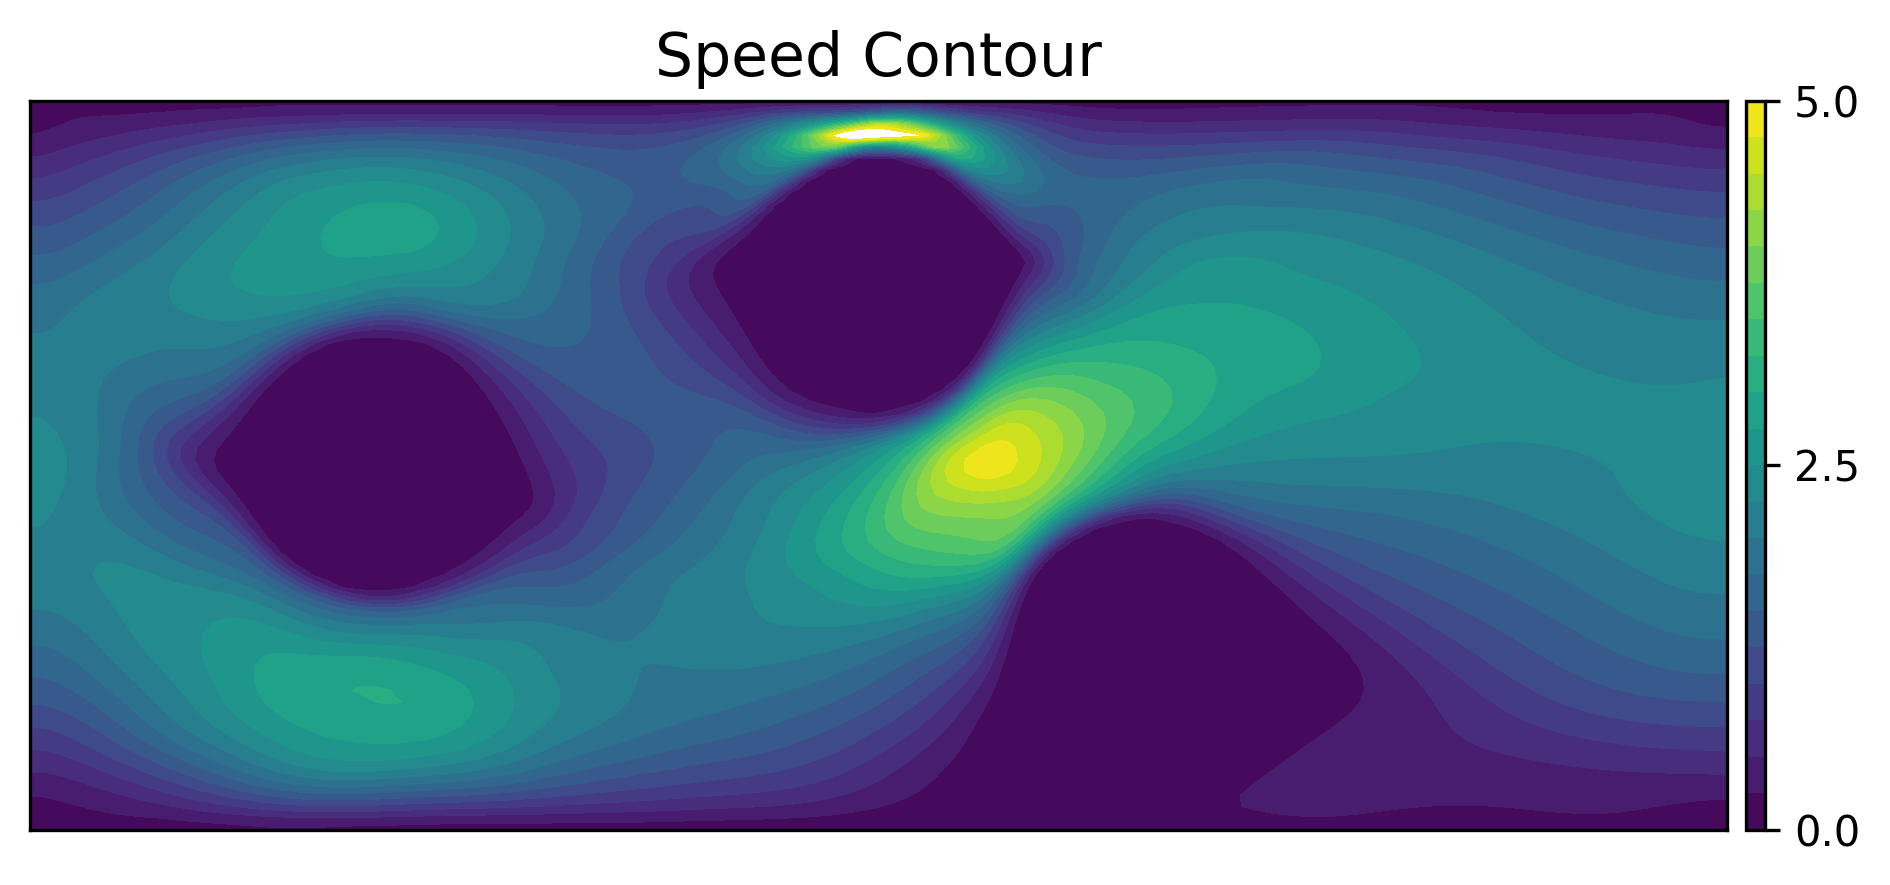

In [21]:
### Plotting

plt.close('all')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6.4, 3.0])
plt.tight_layout(pad=0.75)

## Plot 0

contour0 = ax.contourf(X[:,0].reshape(num_x, num_y).detach().numpy(),
                       X[:,1].reshape(num_x, num_y).detach().numpy(),
                       torch.sqrt(Velocity[:,0]**2 + Velocity[:,1]**2).reshape(num_x, num_y).detach().numpy(),
                       flow_levels, cmap=plt.cm.viridis)

ax.set_title('Speed Contour')

ax.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar0_param = fig.add_axes(
    [ax.get_position().x1 + 0.01,
     ax.get_position().y0,
     0.01,
     ax.get_position().height])
colorbar0 = plt.colorbar(contour0, ticks=flow_ticks, cax = colorbar0_param)
colorbar0.ax.tick_params(labelsize=10)



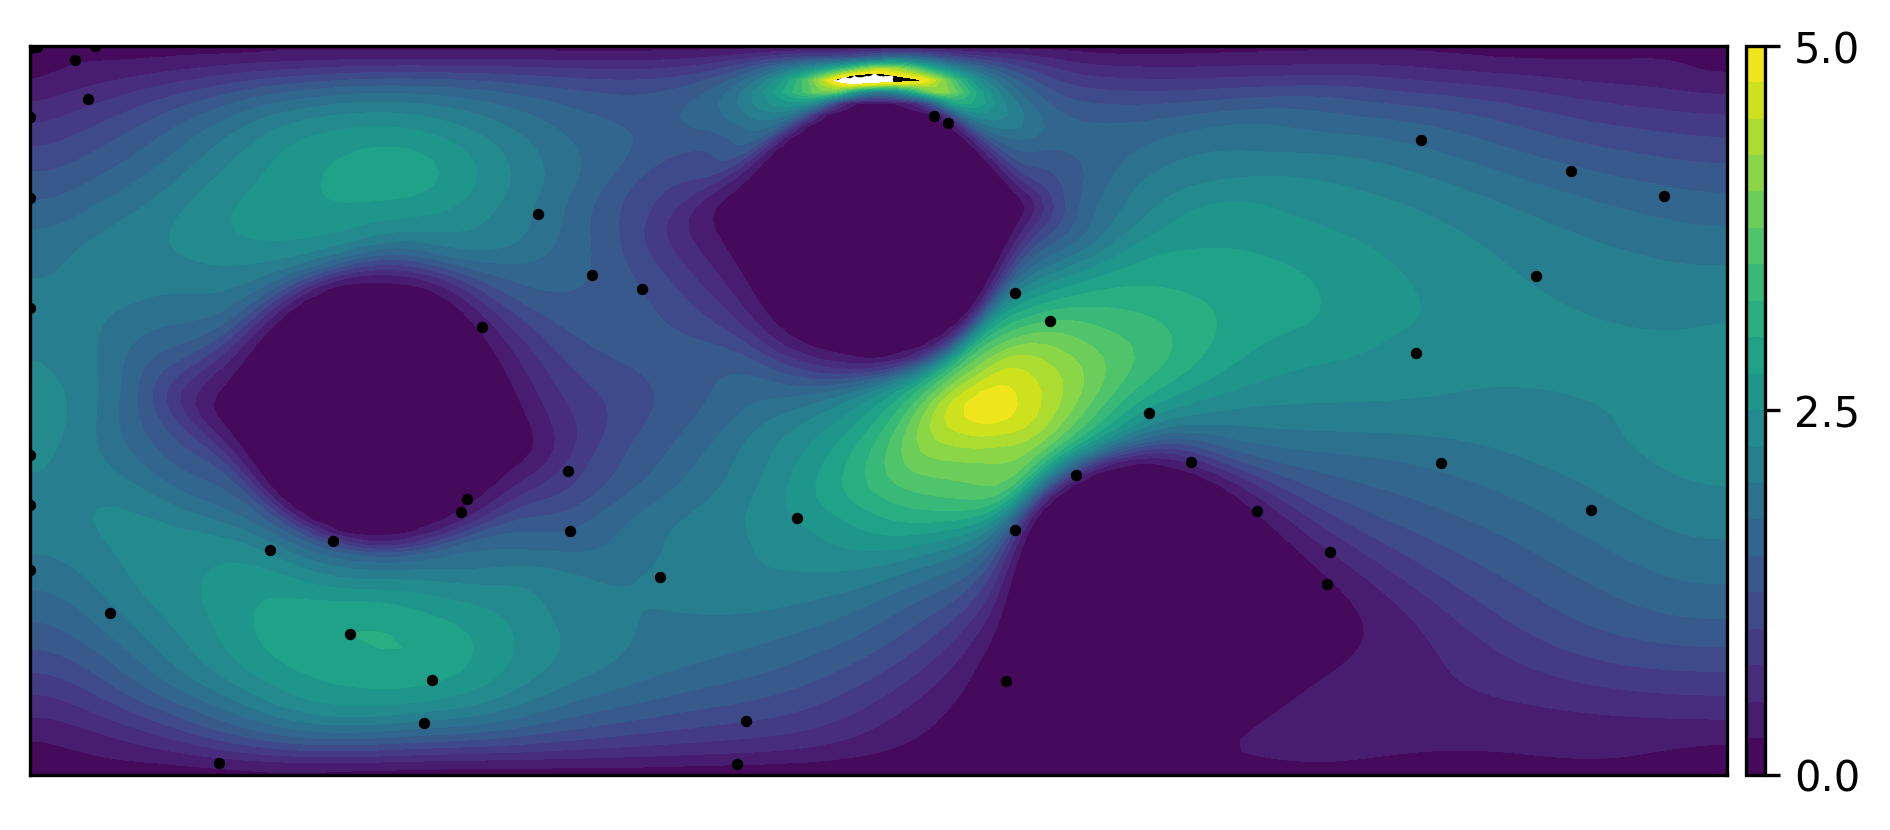

In [28]:
### Make video

plt.close('all')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6.4, 3.0])
plt.tight_layout(pad=0.75)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

ax.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar_param = fig.add_axes(
    [ax.get_position().x1 + 0.01,
     ax.get_position().y0,
     0.01,
     ax.get_position().height])

def RK4(x, h, u):
    ### Calculate x(t+1) from x' = u(x,t) using Runge-Kutta 4
    ### xt = (x,t)
    ### Used for plotting streamlines and making animations with tracer particles

    x0 = x

    k1 = u(x)

    x = x0 + h*k1/2
    k2 = u(x)

    x = x0 + h*k2/2 
    k3 = u(x)

    x = x0 + h*k3
    k4 = u(x)

    x1 = x0 + h/6 * (k1 + k2 + k3 + k4)
    return x1

domain = create.theDomain(problem_parameters)
RandPoints = create.InteriorPoints(50, domain, input_dim, input_range, 'cpu')

h = 0.1
path = '/home/mskpark/Research/DRLPDE/plotting/images/'

lengthofvideo = 15
framerate = 30
numfigs = int(lengthofvideo*framerate)

for ii in range(numfigs):
    plt.cla()
    contour = ax.contourf(X[:,0].reshape(num_x, num_y).detach().numpy(),
                       X[:,1].reshape(num_x, num_y).detach().numpy(),
                       torch.sqrt(Velocity[:,0]**2 + Velocity[:,1]**2).reshape(num_x, num_y).detach().numpy(),
                       flow_levels, cmap=plt.cm.viridis)
    
    colorbar = plt.colorbar(contour, ticks=flow_ticks, cax = colorbar_param)
    colorbar.ax.tick_params(labelsize=10)

    ### Move 
    RandPoints.location = RK4(RandPoints.location.requires_grad_(True), h, model)
    
    # If they're outside, then make a new point at the entrance
    outside = torch.zeros( RandPoints.location.size(0), dtype=torch.bool)
    for wall in domain.checkinside:
        outside += wall.distance(RandPoints.location) < 0

    RandPoints.location[outside,0] = xmin
    RandPoints.location[outside,1] = (ymax - ymin)*torch.rand(torch.sum(outside)) + ymin

    ax.scatter(RandPoints.location[:,0].detach().numpy(),
                RandPoints.location[:,1].detach().numpy(),
                s=3, c='k')

    figname = 'velocityplot' + str(ii) + '.png'

    plt.savefig(path + figname)


In [29]:
img_array = []
for ii in range(numfigs):
    figname = 'velocityplot' + str(ii) + '.png'
    img = cv2.imread(path + figname)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter(path + 'Thesisexample1.avi',cv2.VideoWriter_fourcc(*'DIVX'), framerate, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [26]:
numfigs = 10